## Preamble

In [1]:
# Import packages

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import xarray
import math
import glob
import os
import fiona
import io
import pathlib
import requests

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.transform import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
from rasterio.crs import CRS
from rasterio.features import rasterize

import shapely
from shapely.geometry import Polygon
from shapely.geometry import mapping
from shapely.geometry import box

from tqdm import tqdm
from affine import Affine
from zipfile import ZipFile

import logging
logging.basicConfig(level=logging.INFO)

import atlite
from atlite.gis import ExclusionContainer, shape_availability

In [2]:
aggregated_regions = [
    "AT", "BE", "BG", "CH", "CZ", "DE",
    "DK", "EE", "ES", "FI", "FR", "UK",
    "GR", "HR", "HU", "IE", "IT", "LT",
    "LU", "LV", "NL", "NO", "PL", "PT", 
    "RO", "SE", "SI", "SK",
]

In [3]:
europe = (
    gpd
    .read_file('/home/oskar/shared_input/geodata/onshore/shapes/NUTS_RG_10M_2021_4326.geojson')
    .query("NUTS_ID == @aggregated_regions")
    .set_index(["NUTS_ID"])
    .loc[:,['geometry']]
)

In [4]:
rectx1 = -12
rectx2 = 44
recty1 = 33
recty2 = 72

polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
)
europe = gpd.clip(europe, polygon)

## Functions

In [5]:
def plot_eligible_area(ax, tiff_path, europe, title):
    excluder_wind_onshore = ExclusionContainer()

    full_europe = (
        europe
        .assign(col='a')
        .dissolve(by='col')
        .geometry
    )

    full_europe = full_europe.to_crs(excluder_wind_onshore.crs)

    excluder_wind_onshore.add_raster(tiff_path)
    masked, transform = shape_availability(full_europe, excluder_wind_onshore)
    eligible_share = (masked.sum() * excluder_wind_onshore.res**2 / full_europe.geometry.item().area)
    
    # Plot the eligible area in a subplot
    show(masked, transform=transform, cmap='Greens', ax=ax)
    full_europe.plot(ax=ax, edgecolor='k', color='None')
    europe.to_crs(excluder_wind_onshore.crs).boundary.plot(ax=ax, edgecolor='grey', linewidth=0.2)
    ax.set_title(f'{title} \n Eligible area (green) {eligible_share * 100:2.2f}%')

In [6]:
def get_bounding():
    
    rectx1 = -12
    rectx2 = 44
    recty1 = 33
    recty2 = 72
    
    polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
    )
    
    polygon=shapely.segmentize(polygon, max_segment_length=0.5)
    
    b=gpd.GeoDataFrame(geometry=[polygon],crs="EPSG:4326")
 
    return b.to_crs("EPSG:3035")

In [7]:
def buffer_and_rasterize_layer(gpkg_file, layer_name, buffer_distance, output_tiff):
    os.makedirs(os.path.dirname(output_tiff), exist_ok=True)
    
    # Read the layer from the GeoPackage
    gdf = gpd.read_file(gpkg_file, layer=layer_name).to_crs(get_bounding().crs)

    # Identify geometry type and buffer lines. 
    # The buffer distance for point data can be adjusted as needed.
    if gdf.geom_type.isin(['LineString', 'MultiLineString','Point']).any():
        # Buffer lines
        resolution = 100
        gdf['geometry'] = gdf['geometry'].buffer(buffer_distance)
    elif gdf.geom_type.isin(['Polygon', 'MultiPolygon']).any():
        resolution = 100
        # Potentially simplify polygons or use them directly if necessary
        gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.001)
        gdf['geometry'] = gdf['geometry'].buffer(buffer_distance)
    else:
        raise ValueError("No suitable geometry types found for processing")

    # Calculate the boundary of the output raster
    #minx, miny, maxx, maxy = gdf.total_bounds
    minx = get_bounding().bounds.minx[0]
    maxx = get_bounding().bounds.maxx[0]
    miny = get_bounding().bounds.miny[0]
    maxy = get_bounding().bounds.maxy[0]
    #resolution = 100  # Adjust resolution as needed
    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)
    transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

    # Rasterize the buffered geometries
    rasterized = rasterize(
        [(geom, 1) for geom in gdf.geometry if geom is not None],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    # Write the raster to file with compression
    with rasterio.open(
        output_tiff, 'w',
        driver='GTiff',
        height=rasterized.shape[0],
        width=rasterized.shape[1],
        count=1,
        dtype='uint8',
        crs='EPSG:3035',
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(rasterized, 1)

    print(f'Rasterized buffer saved to {output_tiff}')

In [8]:
def process_geopackages(base_dir, output_tiff, buffer_poly, buffer_line, resolution=100):
    """
    Fetch the euhydro geopackage files, rasterize and buffer around them. 

    Args:
        base_dir: Directory of all subfolders
        output_tiff: Name of output file
        buffer_poly: Buffer distance for polygons
        buffer_line: Buffer distance for linestrings
        resolution: Resolution of output dataset (default = 100m)
    """
    # Define the pattern to match the main GeoPackage files
    main_file_pattern = "euhydro_*_v013.gpkg"

    # List all matching GeoPackage files
    gpkg_files = [os.path.join(root, file)
                  for root, _, files in os.walk(base_dir)
                  for file in files if fnmatch.fnmatch(file, main_file_pattern)]

    # Layers to include
    layers_to_include = ['InlandWater','River_Net_l','Canals_l']  
    # For CRS in meters
    minx, maxx, miny, maxy = get_bounding().bounds.minx[0], get_bounding().bounds.maxx[0], get_bounding().bounds.miny[0], get_bounding().bounds.maxy[0]

    # Prepare rasterization parameters
    width = int((maxx - minx) / resolution)
    height = int((maxy - miny) / resolution)
    transform = from_bounds(minx, miny, maxx, maxy, width, height)
    raster_merged = None

    # Process each layer and add to raster
    for gpkg_file in tqdm(gpkg_files):
        for layer in layers_to_include:
            raster_layer = buffer_and_rasterize_layer_hydro(gpkg_file, layer, buffer_poly, buffer_line, resolution, transform, (height, width))

            # Continue to the next iteration if raster_layer is None
            if raster_layer is None:
                continue
            
            # Accumulate the rasters, maintaining non-zero values
            if raster_merged is None:
                raster_merged = raster_layer
            else:
                raster_merged = raster_merged | raster_layer

    # Write the combined raster to file with compression
    os.makedirs(os.path.dirname(output_tiff), exist_ok=True)
    with rasterio.open(
        output_tiff, 'w',
        driver='GTiff',
        height=raster_merged.shape[0],
        width=raster_merged.shape[1],
        count=1,
        dtype='uint8',
        crs='EPSG:3035',
        transform=transform,
        compress='lzw'
    ) as dst:
        dst.write(raster_merged, 1)

    print(f'Rasterized buffer saved to {output_tiff}')

In [9]:
def buffer_and_rasterize_layer_hydro(gpkg_file, layer_name, buffer_poly, buffer_line, resolution, transform, out_shape):
    # Read the layer from the GeoPackage
    gdf = gpd.read_file(gpkg_file, layer=layer_name)
    gdf = gdf.to_crs(get_bounding().crs)
    print(f'processing {gpkg_file} and layer: {layer_name}')
    print("Unique geometry types in the file:", gdf.geom_type.unique())

    # Check if the GeoDataFrame is empty or has unsupported types
    if gdf.empty or gdf.geom_type.isin(['LineString', 'MultiLineString', 'Point', 'Polygon', 'MultiPolygon']).any() is False:
        print(f"Skipping layer {layer_name} in {gpkg_file} due to unsupported or missing geometries.")
        return None
    
    # Buffer geometries based on their type
    if gdf.geom_type.isin(['LineString', 'MultiLineString', 'Point']).any():
        gdf['geometry'] = gdf['geometry'].buffer(buffer_line)
    elif gdf.geom_type.isin(['Polygon', 'MultiPolygon']).any():
        gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.001)
        gdf['geometry'] = gdf['geometry'].buffer(buffer_poly)


    # Rasterize the buffered geometries
    return rasterize(
        [(geom, 1) for geom in gdf.geometry if geom is not None],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )

## GeoPackage files (.gpkg)

In [ ]:
powerlines = '/home/oskar/shared_input/geodata/onshore/wimby/powerlines.gpkg'
rail = '/home/oskar/shared_input/geodata/onshore/wimby/rail.gpkg'
airports = '/home/oskar/shared_input/geodata/onshore/wimby/airport.gpkg'
glaciers = '/home/oskar/shared_input/geodata/onshore/wimby/glacier.gpkg'
roads_motorways = '/home/oskar/shared_input/geodata/onshore/wimby/roads_motorways.gpkg'
roads_primary = '/home/oskar/shared_input/geodata/onshore/wimby/roads_primary.gpkg'
military = '/home/oskar/shared_input/geodata/onshore/wimby/military.gpkg'
radar = '/home/oskar/shared_input/geodata/onshore/wimby/radar.gpkg'
shipping = '/home/oskar/shared_input/geodata/onshore/wimby/shipping_lanes_high_pass.gpkg'


In [22]:
# Inspect a GeoPackage file to see what layers exist. 

# Specify the path to your GeoPackage file
gpkg_file = '/home/oskar/shared_input/geodata/onshore/wimby/OSMseamarkpoints_merged.gpkg'

# Open the GeoPackage and list its layers
with fiona.Env():
    # Get the list of layers
    layers = fiona.listlayers(gpkg_file)
    
    # Print out the list of layers
    print("Layers available in the GeoPackage:")
    for layer in layers:
        print(layer)

Layers available in the GeoPackage:
points


In [23]:
f = gpd.read_file(gpkg_file)

In [35]:
f.rename(columns={'type' : 'cat'}).cat.unique()

array(['beacon_special_purpose', 'small_craft_facility', 'rock',
       'harbour', 'beacon_isolated_danger', 'light_minor', 'landmark',
       'cable_overhead', 'light_major', 'beacon_lateral', 'wreck',
       'buoy_lateral', 'restricted_area', 'light', 'buoy_special_purpose',
       'buoy_safe_water', 'sea_area', 'buoy_cardinal',
       'buoy_isolated_danger', 'notice', 'building', 'berth', 'platform',
       'beacon_cardinal', 'beacon_safe_water', 'mooring', 'pile',
       'radar_station', 'gate', 'daymark', 'pylon', 'crane',
       'light_float', 'anchorage', 'waterway_gauge',
       'light_minor;beacon_lateral', 'signal_station_traffic',
       'rescue_station', 'bridge', 'fortified_structure', 'distance_mark',
       'obstruction', 'radio_station', 'tank', 'anchor_berth',
       'recommended_track', 'virtual_aton', 'pilot_boarding',
       'light_vessel', 'signal_station_warning', 'marine_farm',
       'control_point', 'fishing_facility', 'seabed_area',
       'calling-in_point', 

In [ ]:
# Define a dictionary with each key as GeoPackage file and value as list of layers with their buffer distances
buffer_dict = {
    'shipping_lanes_high_pass.gpkg': [
        {'layer_name': 'shipping_lanes_high_pass', 'buffer_distance': 0},
    ],
    'radar.gpkg': [
        {'layer_name': 'radar', 'buffer_distance': 6000},
    ],
    'military.gpkg': [
        {'layer_name': 'military', 'buffer_distance': 5500},
    ],
    'rail.gpkg': [
        {'layer_name': 'rail', 'buffer_distance': 190},
        {'layer_name': 'narrow', 'buffer_distance': 190}
    ],
    'airport.gpkg': [
        {'layer_name': 'airports', 'buffer_distance': 6000}
    ],
    'powerlines.gpkg': [
        {'layer_name': 'powerlines', 'buffer_distance': 165}
    ],
    'glacier.gpkg': [
        {'layer_name': 'glacier', 'buffer_distance': 0}
    ],
    'roads_motorways.gpkg': [
        {'layer_name': 'motorway', 'buffer_distance': 165},
        {'layer_name': 'motorway_link', 'buffer_distance': 165},
        {'layer_name': 'trunk', 'buffer_distance': 165}
    ],
    'roads_primary.gpkg': [
        {'layer_name': 'primary', 'buffer_distance': 165}
    ]
}


In [ ]:
gpkg_files = [
    #powerlines,
    #rail,
    #airports,
    #glaciers,
    #roads_motorways,
    roads_primary,
    #military,
    #radar,
    #shipping,
]

# Loop over each GeoPackage file and its respective layers
for gpkg_file in tqdm(gpkg_files):
    print(gpkg_file)
    base_name = gpkg_file.split('/')[-1]  # Extract filename
    if base_name in buffer_dict:
        for layer_info in buffer_dict[base_name]:
            layer_name = layer_info['layer_name']
            buffer_distance = layer_info['buffer_distance']
            output_tiff = f'/home/oskar/shared_input/geodata/onshore/wimby/processed/{base_name.replace(".gpkg", "")}_{layer_name}_buffered.tif'
            buffer_and_rasterize_layer(gpkg_file, layer_name, buffer_distance, output_tiff)


### Rivers

In [10]:
import warnings
import fnmatch
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [11]:
# Example usage
base_directory = "/home/oskar/Downloads/EU_hydro_gpkg_eu/"
output_file = "/home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered175_175.tif"
buffer_poly = 175
buffer_line = 175

process_geopackages(base_directory, output_file, buffer_poly, buffer_line)

  0%|                                                    | 0/30 [00:00<?, ?it/s]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_mesima_v013_GPKG/euhydro_mesima_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_mesima_v013_GPKG/euhydro_mesima_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_mesima_v013_GPKG/euhydro_mesima_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


  3%|█▍                                          | 1/30 [00:20<09:44, 20.15s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_seine_v013_GPKG/euhydro_seine_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_seine_v013_GPKG/euhydro_seine_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_seine_v013_GPKG/euhydro_seine_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


  7%|██▉                                         | 2/30 [00:48<11:33, 24.76s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_danube_v013_GPKG/euhydro_danube_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_danube_v013_GPKG/euhydro_danube_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_danube_v013_GPKG/euhydro_danube_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 10%|████▍                                       | 3/30 [02:42<29:34, 65.72s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vorma_v013_GPKG/euhydro_vorma_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vorma_v013_GPKG/euhydro_vorma_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vorma_v013_GPKG/euhydro_vorma_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 13%|█████▊                                      | 4/30 [03:26<24:47, 57.23s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_shannon_v013_GPKG/euhydro_shannon_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_shannon_v013_GPKG/euhydro_shannon_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_shannon_v013_GPKG/euhydro_shannon_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 17%|███████▎                                    | 5/30 [03:42<17:35, 42.22s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_angerman_v013_GPKG/euhydro_angerman_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_angerman_v013_GPKG/euhydro_angerman_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_angerman_v013_GPKG/euhydro_angerman_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 20%|████████▊                                   | 6/30 [04:46<19:48, 49.54s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_thames_v013_GPKG/euhydro_thames_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_thames_v013_GPKG/euhydro_thames_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_thames_v013_GPKG/euhydro_thames_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 23%|██████████▎                                 | 7/30 [05:10<15:49, 41.28s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_loire_v013_GPKG/euhydro_loire_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_loire_v013_GPKG/euhydro_loire_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_loire_v013_GPKG/euhydro_loire_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 27%|███████████▋                                | 8/30 [05:39<13:39, 37.24s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_jucar_v013_GPKG/euhydro_jucar_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_jucar_v013_GPKG/euhydro_jucar_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_jucar_v013_GPKG/euhydro_jucar_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 30%|█████████████▏                              | 9/30 [05:54<10:38, 30.41s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_neva_v013_GPKG/euhydro_neva_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_neva_v013_GPKG/euhydro_neva_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_neva_v013_GPKG/euhydro_neva_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 33%|██████████████▎                            | 10/30 [07:26<16:29, 49.46s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vistula_v013_GPKG/euhydro_vistula_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vistula_v013_GPKG/euhydro_vistula_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_vistula_v013_GPKG/euhydro_vistula_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 37%|███████████████▊                           | 11/30 [08:00<14:10, 44.76s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tevere_v013_GPKG/euhydro_tevere_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tevere_v013_GPKG/euhydro_tevere_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']


 40%|█████████████████▏                         | 12/30 [08:10<10:16, 34.24s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tevere_v013_GPKG/euhydro_tevere_v013.gpkg and layer: Canals_l
Unique geometry types in the file: []
Skipping layer Canals_l in /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tevere_v013_GPKG/euhydro_tevere_v013.gpkg due to unsupported or missing geometries.
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhine_v013_GPKG/euhydro_rhine_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhine_v013_GPKG/euhydro_rhine_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhine_v013_GPKG/euhydro_rhine_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 43%|██████████████████▋                        | 13/30 [08:52<10:18, 36.40s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_duero_v013_GPKG/euhydro_duero_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_duero_v013_GPKG/euhydro_duero_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_duero_v013_GPKG/euhydro_duero_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 47%|████████████████████                       | 14/30 [09:21<09:07, 34.24s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tirso_v013_GPKG/euhydro_tirso_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tirso_v013_GPKG/euhydro_tirso_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tirso_v013_GPKG/euhydro_tirso_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 50%|█████████████████████▌                     | 15/30 [09:34<06:56, 27.76s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_gota_v013_GPKG/euhydro_gota_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_gota_v013_GPKG/euhydro_gota_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_gota_v013_GPKG/euhydro_gota_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 53%|██████████████████████▉                    | 16/30 [10:21<07:49, 33.50s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_ebro_v013_GPKG/euhydro_ebro_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_ebro_v013_GPKG/euhydro_ebro_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_ebro_v013_GPKG/euhydro_ebro_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 57%|████████████████████████▎                  | 17/30 [10:45<06:39, 30.72s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_oder_v013_GPKG/euhydro_oder_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_oder_v013_GPKG/euhydro_oder_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_oder_v013_GPKG/euhydro_oder_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 60%|█████████████████████████▊                 | 18/30 [11:10<05:48, 29.03s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_po_v013_GPKG/euhydro_po_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_po_v013_GPKG/euhydro_po_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_po_v013_GPKG/euhydro_po_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 63%|███████████████████████████▏               | 19/30 [11:46<05:43, 31.23s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_elbe_v013_GPKG/euhydro_elbe_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_elbe_v013_GPKG/euhydro_elbe_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_elbe_v013_GPKG/euhydro_elbe_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 67%|████████████████████████████▋              | 20/30 [12:15<05:06, 30.63s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_kemi_v013_GPKG/euhydro_kemi_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_kemi_v013_GPKG/euhydro_kemi_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_kemi_v013_GPKG/euhydro_kemi_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 70%|██████████████████████████████             | 21/30 [12:58<05:09, 34.35s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tana_v013_GPKG/euhydro_tana_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tana_v013_GPKG/euhydro_tana_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']


 73%|███████████████████████████████▌           | 22/30 [13:50<05:15, 39.42s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tana_v013_GPKG/euhydro_tana_v013.gpkg and layer: Canals_l
Unique geometry types in the file: []
Skipping layer Canals_l in /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tana_v013_GPKG/euhydro_tana_v013.gpkg due to unsupported or missing geometries.
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_guadalquivir_v013_GPKG/euhydro_guadalquivir_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_guadalquivir_v013_GPKG/euhydro_guadalquivir_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_guadalquivir_v013_GPKG/euhydro_guadalquivir_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 77%|████████████████████████████████▉          | 23/30 [14:12<04:00, 34.30s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_nemunas_v013_GPKG/euhydro_nemunas_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_nemunas_v013_GPKG/euhydro_nemunas_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_nemunas_v013_GPKG/euhydro_nemunas_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 80%|██████████████████████████████████▍        | 24/30 [14:52<03:36, 36.12s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhone_v013_GPKG/euhydro_rhone_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhone_v013_GPKG/euhydro_rhone_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_rhone_v013_GPKG/euhydro_rhone_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 83%|███████████████████████████████████▊       | 25/30 [15:19<02:46, 33.39s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tajo_v013_GPKG/euhydro_tajo_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tajo_v013_GPKG/euhydro_tajo_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tajo_v013_GPKG/euhydro_tajo_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 87%|█████████████████████████████████████▎     | 26/30 [15:57<02:18, 34.57s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_skjern_v013_GPKG/euhydro_skjern_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_skjern_v013_GPKG/euhydro_skjern_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_skjern_v013_GPKG/euhydro_skjern_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 90%|██████████████████████████████████████▋    | 27/30 [16:17<01:30, 30.29s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tweed_v013_GPKG/euhydro_tweed_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tweed_v013_GPKG/euhydro_tweed_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_tweed_v013_GPKG/euhydro_tweed_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 93%|████████████████████████████████████████▏  | 28/30 [16:45<00:59, 29.52s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_garonne_v013_GPKG/euhydro_garonne_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_garonne_v013_GPKG/euhydro_garonne_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_garonne_v013_GPKG/euhydro_garonne_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


 97%|█████████████████████████████████████████▌ | 29/30 [17:09<00:28, 28.04s/it]

processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_pinios_v013_GPKG/euhydro_pinios_v013.gpkg and layer: InlandWater
Unique geometry types in the file: ['MultiPolygon']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_pinios_v013_GPKG/euhydro_pinios_v013.gpkg and layer: River_Net_l
Unique geometry types in the file: ['MultiLineString']
processing /home/oskar/Downloads/EU_hydro_gpkg_eu/euhydro_pinios_v013_GPKG/euhydro_pinios_v013.gpkg and layer: Canals_l
Unique geometry types in the file: ['MultiLineString']


100%|███████████████████████████████████████████| 30/30 [17:45<00:00, 35.51s/it]


Rasterized buffer saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/hydro_buffered175_175.tif


## Existing rasters (.tif)

In [13]:
slope = '/home/oskar/shared_input/geodata/onshore/euro_slope_40degs.tif'

In [14]:
convert_slope = 'Yes' # Turn on when the slope file (36 degrees) needs to be converted

In [18]:
if convert_slope == 'Yes':
    minx, miny, maxx, maxy = get_bounding().total_bounds
    # Open the existing raster
    with rasterio.open(slope) as src:
        # Calculate transform of the new intended output dimensions
        new_transform = Affine.translation(minx, maxy) * Affine.scale(
            (maxx - minx) / src.width,
            (miny - maxy) / src.height)

        # Calculate new width and height
        new_width = int((maxx - minx) / new_transform.a)
        new_height = int((maxy - miny) / -new_transform.e)

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': CRS.from_epsg(3035),
            'transform': new_transform,
            'width': new_width,
            'height': new_height,
            'compress': 'lzw'  # Add LZW compression
        })

        with rasterio.open('/home/oskar/shared_input/geodata/onshore/wimby/processed/euro_slope_40degs.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=new_transform,
                    dst_crs=CRS.from_epsg(3035),
                    resampling=Resampling.nearest)

## Shapefiles (.shp)

In [12]:
convert_shapefiles = 'Yes'

In [14]:
shapefile_paths = [
    '/home/oskar/shared_input/geodata/onshore/15degrees.shp.zip',
    '/home/oskar/shared_input/geodata/onshore/2000m.shp.zip'
]
# NOTE THAT IF NEW FILES ARE ADDED, IT NEEDS TO BE VERIFIED THAT THE RELEVANT DATA IS WHERE GRIDCODE = 2

if convert_shapefiles == 'Yes':
    minx, miny, maxx, maxy = get_bounding().total_bounds
    for file in tqdm(shapefile_paths):
        # Define your spatial extent and resolution
        resolution = 100  # Set appropriate resolution (100m as an example)
        
        # Unzip the shapefile
        shapefile_zip = file
        with ZipFile(shapefile_zip, 'r') as z:
            z.extractall(path='temp_directory')
        
        # Load the shapefile
        shapefile_path = [name for name in z.namelist() if name.endswith('.shp')][0]
        shapefile_path = os.path.join('temp_directory', shapefile_path)
        gdf = gpd.read_file(shapefile_path)
        gdf = gdf.query("gridcode == 2")
        
        # Transform the GeoDataFrame to your desired CRS, if necessary
        gdf = gdf.to_crs(get_bounding().crs)
        
        # Generate a mask for the rasterization
        transform = from_bounds(minx, miny, maxx, maxy, int((maxx - minx) / resolution), int((maxy - miny) / resolution))
        
        # Rasterize the GeoDataFrame
        out_shape = (int((maxy - miny) / resolution), int((maxx - minx) / resolution))
        rasterized = rasterize(
            [(geom, 1) for geom in gdf.geometry], 
            out_shape=out_shape,
            transform=transform,
            fill=0,
            all_touched=True,
            dtype='uint8'
        )
        
        # Define the raster metadata
        raster_meta = {
            'driver': 'GTiff',
            'height': out_shape[0],
            'width': out_shape[1],
            'count': 1,
            'dtype': 'uint8',
            'crs': 'EPSG:3035',
            'transform': transform,
            'compress': 'lzw'  # Apply compression
        }
        
        # Write the raster to a file
        output_raster = f'/home/oskar/shared_input/geodata/onshore/wimby/processed/{file.split('/')[-1].split('.')[-3]}.tif'
        with rasterio.open(output_raster, 'w', **raster_meta) as dst:
            dst.write(rasterized, 1)
        
        # Clean up temporary directory if necessary
        import shutil
        shutil.rmtree('temp_directory')
        
        print(f"Raster saved to {output_raster}")


 50%|██████████████████████▌                      | 1/2 [00:17<00:17, 17.97s/it]

Raster saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/15degrees.tif


100%|█████████████████████████████████████████████| 2/2 [00:26<00:00, 13.22s/it]

Raster saved to /home/oskar/shared_input/geodata/onshore/wimby/processed/2000m.tif


## Plots

In [19]:
name_dict = {
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/airport_airports_buffered.tif' : 'Airports 5km buffer',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/euro_slope_40degs.tif' : 'Slope 36°',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/15degrees.tif' : 'Slope 15°',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/powerlines_powerlines_buffered.tif' : 'Powerlines',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_narrow_buffered.tif' : 'Rail - Narrow',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_rail_buffered.tif' : 'Rail - Rail',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/glacier_glacier_buffered.tif' : 'Glaciers',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_link_buffered.tif' : 'Roads - Motorways_link',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_buffered.tif' : 'Roads - Motorways_motorway',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_trunk_buffered.tif' : 'Roads - Motorways_trunk',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_primary_primary_buffered.tif': 'Roads - Primary',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/military_military_buffered.tif': 'Military 5.5km buffer',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/radar_radar_buffered.tif': 'Radars 6km buffer',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/2000m.tif': 'Elevation (2000m)',
    '/home/oskar/shared_input/geodata/onshore/wimby/shipping_lanes_high_pass.gpkg': 'Shipping lanes',
}

In [36]:
tiff_paths = [
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/airport_airports_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/15degrees.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/euro_slope_40degs.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/powerlines_powerlines_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_narrow_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/rail_rail_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_trunk_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/glacier_glacier_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_motorways_motorway_link_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/military_military_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/radar_radar_buffered.tif',
    '/home/oskar/shared_input/geodata/onshore/wimby/processed/2000m.tif',
   #'/home/oskar/shared_input/geodata/onshore/wimby/processed/roads_primary_primary_buffered.tif',
    #'/home/oskar/shared_input/geodata/onshore/wimby/processed/shipping_lanes_high_pass_shipping_lanes_high_pass_buffered.tif'
]

0it [00:00, ?it/s]/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


Plotting /home/oskar/shared_input/geodata/onshore/wimby/processed/airport_airports_buffered.tif


1it [01:44, 104.45s/it]/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


Plotting /home/oskar/shared_input/geodata/onshore/wimby/processed/15degrees.tif


2it [03:59, 122.42s/it]/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


Plotting /home/oskar/shared_input/geodata/onshore/wimby/processed/euro_slope_40degs.tif


3it [06:28, 134.60s/it]/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


Plotting /home/oskar/shared_input/geodata/onshore/wimby/processed/powerlines_powerlines_buffered.tif


4it [10:02, 165.86s/it]/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


Plotting /home/oskar/shared_input/geodata/onshore/wimby/processed/rail_narrow_buffered.tif


5it [16:03, 236.24s/it]/home/oskar/miniconda3/envs/analysis/lib/python3.12/site-packages/atlite/gis.py:489: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


Plotting /home/oskar/shared_input/geodata/onshore/wimby/processed/rail_rail_buffered.tif


5it [17:47, 213.54s/it]


KeyboardInterrupt: 

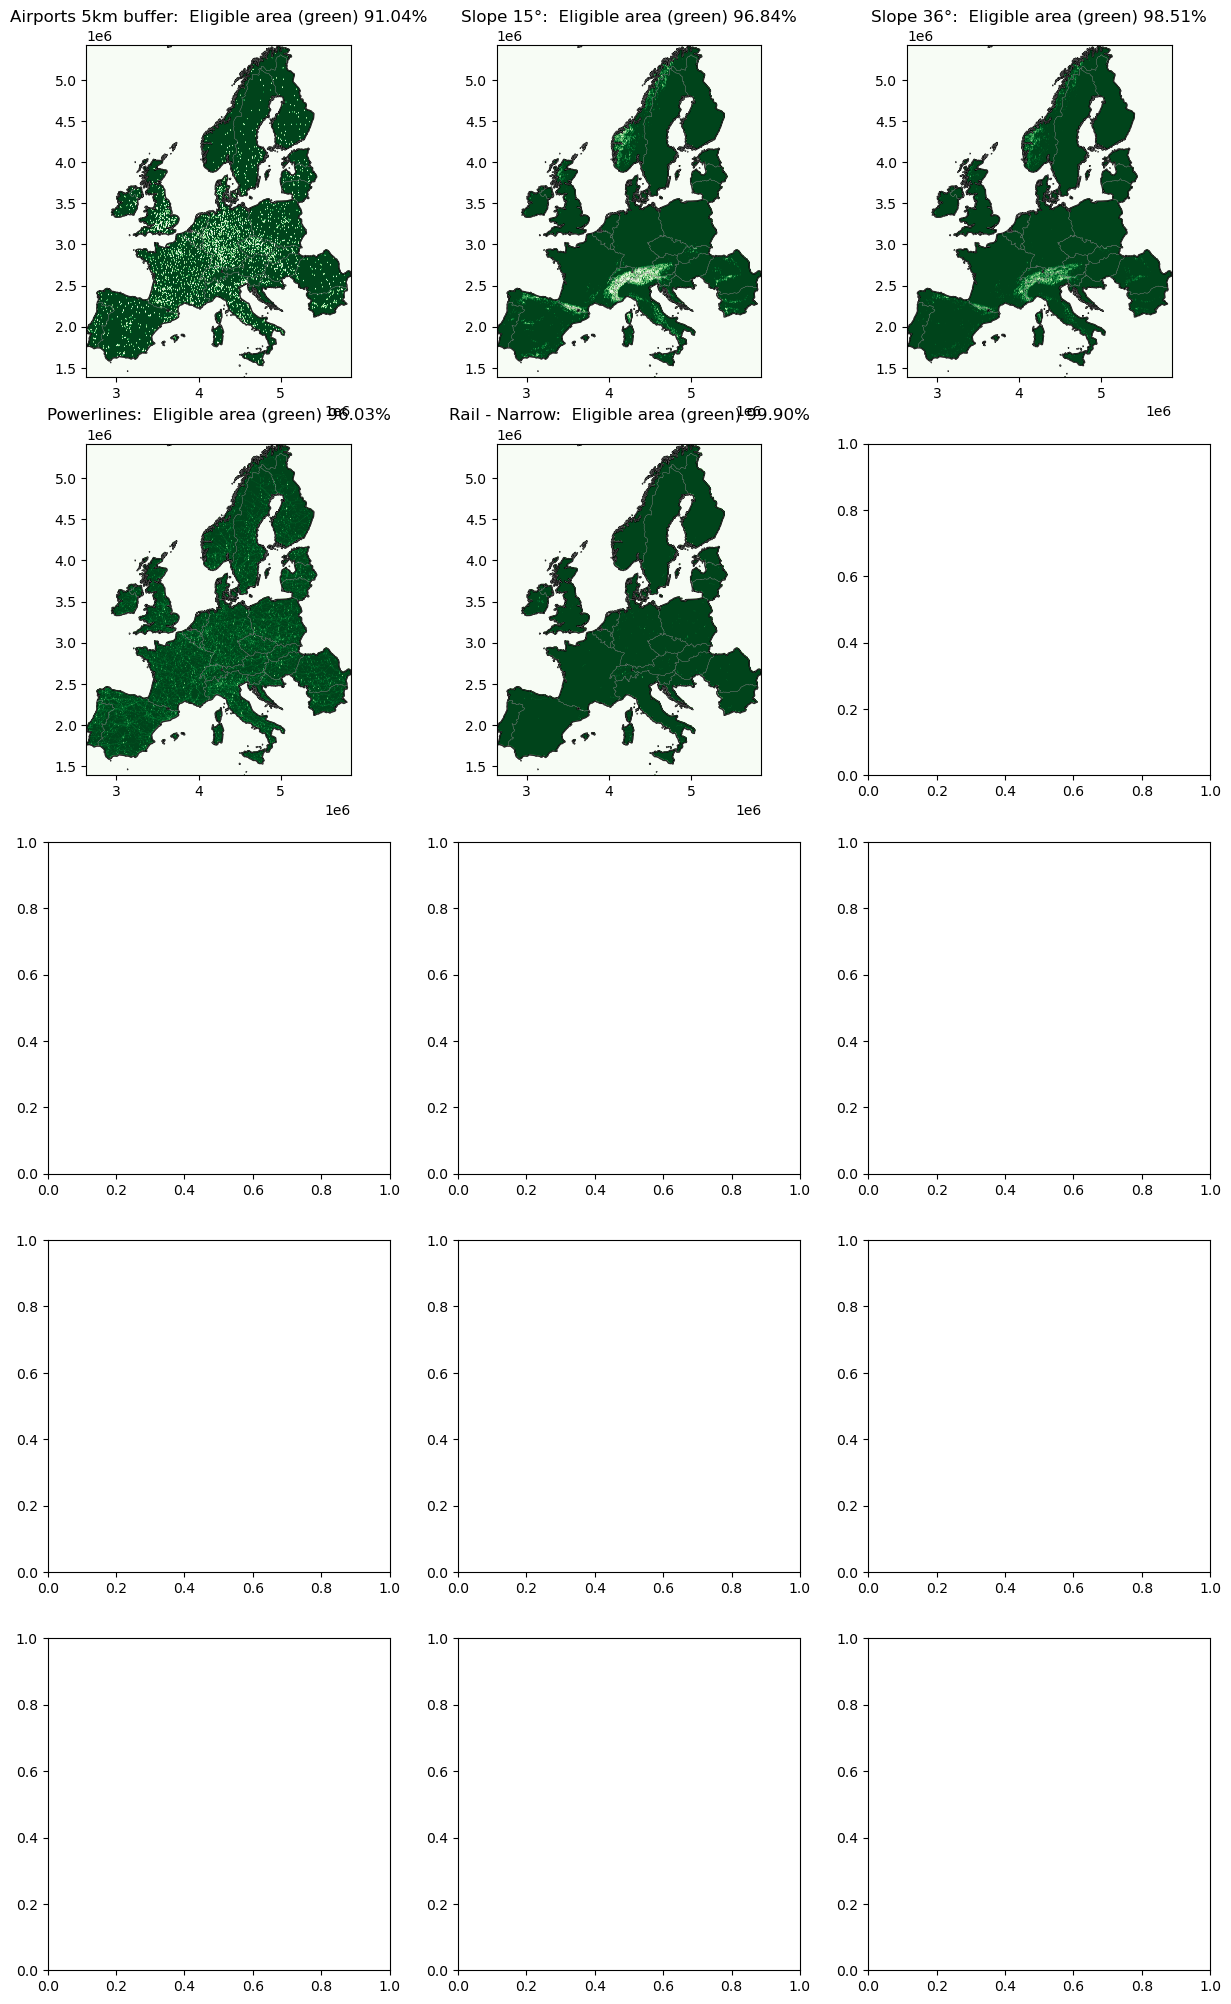

In [37]:
# Create subplots - one for each file
n_files = len(tiff_paths)
columns = 3
rows = math.ceil(n_files/columns)

fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 5 * rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each file on the corresponding subplot
for ax, tiff_path in tqdm(zip(axes, tiff_paths)):
    print(f'Plotting {tiff_path}')
    plot_eligible_area(ax, tiff_path, europe, f'{name_dict.get(tiff_path)}: ')

# Turn off unused subplots
for ax in axes[n_files:]:
    ax.set_visible(False)
    
output_name = 'all_onshore_categories'
extensions = ['.pdf','.png']
for extension in extensions:
    plt.tight_layout()
    plt.savefig(f'{output_name}{extension}',bbox_inches='tight')
plt.show()
